# Overview
The goal of this script is to create engine evaluations for the moves of the player in question grouped by game stage.

For this, I will use the "stockfish" package. https://pypi.org/project/stockfish/

Furthermore, I will divide each game into the sections opening, middle game and endgame.

## Imports and Data load

In [1]:
%pip install stockfish
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install pingouin

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from stockfish import Stockfish


In [14]:
df = pd.read_csv("../data/rapid_games(LAN).csv")
df["LAN"] = df["LAN"].str.split()

### Setting up Stockfish
Setting parameters can be found here: https://github.com/official-stockfish/Stockfish/wiki/UCI-&-Commands

In [9]:
stockfish = Stockfish("C:/Users/phili/stockfish-windows-x86-64-avx2/stockfish/stockfish-windows-x86-64-avx2.exe")
stockfish.get_parameters()
stockfish.update_engine_parameters({"Hash": 2048,"Threads": 8})

## Move evaluation

In [17]:
def evaluate_move():
    """
    return: return a move's evaluation compared to the previous position (in centipawns).
    """
    mate_eval = 1400
    eval = stockfish.get_evaluation()

    if eval["type"] == "cp":
        return eval['value']
    else:
        if eval["value"] > 0:
            return mate_eval
        elif eval["value"] < 0:
            return mate_eval * -1
        else:
            return "checkmate"

In [185]:
def plot_evals(evals):
    plt.figure(figsize=(20,6))
    plt.plot(evals)
    plt.ylim(-1500,1500)
    plt.axhline(0, color="black", linestyle="dotted")

### Depth of Search: Speed-Accuracy Tradeoff
- generally it is desirable to have a deeper stockfish evaluation, however, the time cost increases exponentially.

In [96]:
depths = [16, 18, 20, 22, 24, 26, 28]
times = []
evals_per_depth = []
import time

for depth in depths:
    stockfish.set_depth(depth)

    start = time.time()
    stockfish.set_position()
    evals = [stockfish.get_evaluation()["value"]]
    for move in move_list:
        stockfish.make_moves_from_current_position([move])
        evals.append(evaluate_move(move))
    evals_per_depth.append(evals)
    times.append(time.time() - start)


Text(0.5, 1.0, 'Evaluation Time Cost by Depth (56-move game)')

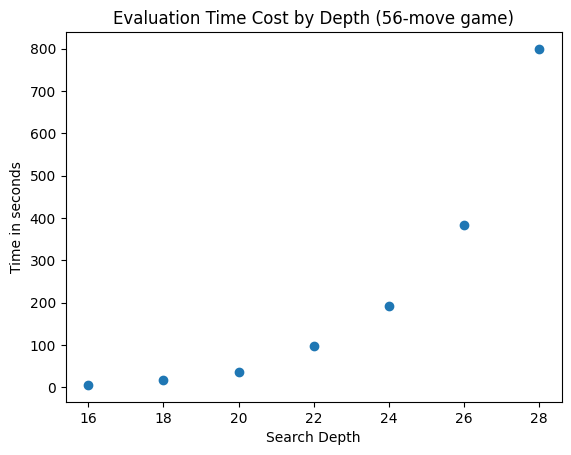

In [104]:
plt.scatter(depths, times)
plt.ylabel("Time in seconds")
plt.xlabel("Search Depth")
plt.title(f"Evaluation Time Cost by Depth ({len(move_list)}-move game)")

- I read online that a depth of 20+ is recommended for reliable evaluations
- For this small sample of 5539 games the time cost would be approximately:

In [139]:
time_cost = pd.DataFrame(depths, columns=["depth"])
time_cost["computational cost in hours"] = list(map(lambda x: x* 5539/3600, times))
time_cost["computational cost in hours"] = time_cost["computational cost in hours"].astype(int)
time_cost

,depth,computational cost in hours
0,16,8
1,18,24
2,20,54
3,22,149
4,24,296
5,26,588
6,28,1229


## Ideas to deal with this problem:
- exclude users who have many games
- randomly sample a portion of the total games for each user
- restrict time range
- create a look-up table for move sequences that were already computed to avoid recomputations
- compute multiple games in parallel

## Material
  Pieces are valued with the following points:
  - queen: 9 points.
  - rook: 5 points.
  - bishop/Knight: 3 points.
  - pawn: 1 point.

In [13]:
def get_piece_value(piece):
    piece_values = {
        # White:
        "K": 0,
        "Q": 9,
        "R": 5,
        "B": 3,
        "N": 3,
        "P": 1,
        # Black:
        "k": 0,
        "q": -9,
        "r": -5,
        "b": -3,
        "n": -3,
        "p": -1,
    }
    try: 
        return piece_values[piece.value]
    except AttributeError:  # case when no piece is on a given square
        return 0

## Game stage
- Opening is defined as: Moves 1-10
- Middlegame is defined as: Moves after middle game and before endgame
- Endgame is defined as: from the move at which both sides have less than *13 points* in material. This definition is adopted from Speelman (Speelman, Jonathan (1981), Endgame Preparation, Batsford, ISBN 0-7134-4000-7 - https://en.wikipedia.org/wiki/Chess_endgame#The_start_of_the_endgame)

In [14]:
def get_material_counts():
    files = string.ascii_lowercase[0:8] # get a-h
    white, black = 0, 0
    
    for file in files:
        for rank in range(1,9):
            piece = stockfish.get_what_is_on_square(file+str(rank)) # returns None if there is no piece
            if not piece:
                pass
            piece_value = get_piece_value(piece)
            if piece_value > 0:
                white += piece_value
            else:
                black += abs(piece_value)
    return (white, black)


## Putting it all together

Now that we have all the elements needed to analyze an entire game and defined how to evaluate the game stage, we can write a function to analyze an entire game given the move-sequence in LAN notation.

In [15]:
def get_evaluations(moves: list):
    stage, evals = [],[]
    # set up board position:
    stockfish.set_position()
    # loop through the game
    reached_endgame = False # once you enter the endgame, you can never go back
    for i, move in enumerate(moves):
        stockfish.make_moves_from_current_position([move])
        evals.append(evaluate_move(move))
        if i < 20:
            stage.append("opening")
        elif not reached_endgame and max(get_material_counts()) > 13:
            stage.append("middle")
        else:
            stage.append("ending")
    
    evals[-1] = evals[-2] if evals[-1] == "checkmate"
    return (evals, stage)

In [21]:
# applying it to the 
rapid_games["LAN"] = rapid_games["LAN"].str.split()
rapid_games["evaluation"] = rapid_games.apply(lambda x: get_evaluations(x["LAN"]), axis=1)

In [ ]:
evals = pd.DataFrame(df["evaluation"].to_list(), columns=["evaluation", "stage"])
rapid_games = df.drop(labels="evaluation", axis=1)
rapid_games = pd.concat([rapid_games, evals], axis=1)
rapid_games

### Load data

In [28]:
import ast

rapid_games = pd.read_csv("../data/rapid_games_evals.csv")


mapping = {
    "username": "category",
    "id": "string",
    "rated": "boolean",
    "status": "category",
    "winner": "category",
    "outcome": "category",
}
rapid_games = rapid_games.astype(mapping)

# convert date strings to date time:
rapid_games["createdAt"] = rapid_games["createdAt"].apply(pd.Timestamp)
rapid_games["lastMoveAt"] = rapid_games["lastMoveAt"].apply(pd.Timestamp)

# convert list strings to lists:
rapid_games["LAN"] = rapid_games["LAN"].apply(ast.literal_eval)
rapid_games["evaluation"] = rapid_games["evaluation"].apply(ast.literal_eval)
rapid_games["stage"] = rapid_games["stage"].apply(ast.literal_eval)
rapid_games["cp_losses"] = rapid_games["cp_losses"].apply(ast.literal_eval)
rapid_games["moveTimes"] = rapid_games["moveTimes"].apply(ast.literal_eval)

rapid_games.info() #.astype(mapping)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539 entries, 0 to 5538
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   username          5539 non-null   category           
 1   id                5539 non-null   string             
 2   rated             5539 non-null   boolean            
 3   createdAt         5539 non-null   datetime64[ns, UTC]
 4   lastMoveAt        5539 non-null   datetime64[ns, UTC]
 5   status            5539 non-null   category           
 6   winner            5250 non-null   category           
 7   moves             5539 non-null   object             
 8   white             5533 non-null   object             
 9   black             5532 non-null   object             
 10  outcome           5539 non-null   category           
 11  LAN               5539 non-null   object             
 12  evaluation        5539 non-null   object             
 13  sta

In [7]:
rapid_games

,username,id,rated,createdAt,lastMoveAt,status,winner,moves,white,black,...,LAN,evaluation,stage,cp_losses,averaged_cp_loss,blunders,clocks,timeFormat,increment,moveTimes
0,AnishPanda2016,https://lichess.org/gEV7P53H,True,2023-11-26 18:28:34.676000+00:00,2023-11-26 18:41:12.851000+00:00,mate,white,d4 Nc6 Bf4 d6 Nf3 e5 dxe5 dxe5 Qxd8+ Kxd8 Nxe5...,AnishPanda2016,Kanishkarr,...,"[d2d4, b8c6, c1f4, d7d6, g1f3, e7e5, d4e5, d6e...","[29, 76, 41, 39, 42, 100, 108, 185, 188, 179, ...","[opening, opening, opening, opening, opening, ...","[0, 35, -3, -8, -3, -14, 19, 35, 3, 125, 197, ...",36.421053,0,"[90003, 90003, 89395, 89411, 89283, 89059, 892...","{'initial': 900, 'increment': 2, 'totalTime': ...",2,"[8.08, 3.12, 2.64, 3.44, 3.04, 1.68, 13.92, 1...."
1,AnishPanda2016,https://lichess.org/rbH7xjlt,True,2023-11-26 17:55:36.746000+00:00,2023-11-26 18:17:46.865000+00:00,mate,black,e4 e6 d4 d5 e5 c5 c3 Nc6 Nf3 Bd7 Bb5 g6 Bxc6 B...,RidhigaA,AnishPanda2016,...,"[e2e4, e7e6, d2d4, d7d5, e4e5, c7c5, c2c3, b8c...","[33, 42, 36, 39, 24, 33, 41, 39, 39, 31, -125,...","[opening, opening, opening, opening, opening, ...","[9, 3, 9, -2, -8, 221, 1, 64, 56, 102, 34, 77,...",54.050000,3,"[90003, 90003, 89995, 90011, 90027, 89947, 900...","{'initial': 900, 'increment': 2, 'totalTime': ...",2,"[1.92, 2.64, 5.04, 14.48, 12.32, 1.84, 4.48, 6..."
2,AnishPanda2016,https://lichess.org/yEfaqwzO,True,2023-11-26 17:44:06.026000+00:00,2023-11-26 17:55:30.791000+00:00,stalemate,NaN,d4 d5 Bf4 Bf5 Nf3 Nc6 e3 Nf6 c3 e6 Bd3 Bg6 Qc2...,AnishPanda2016,AmazingRithvik,...,"[d2d4, d7d5, c1f4, c8f5, g1f3, b8c6, e2e3, g8f...","[31, 33, 17, 28, 17, 41, 32, 77, 18, 18, 0, 36...","[opening, opening, opening, opening, opening, ...","[0, 16, 11, 9, 59, 18, 27, 28, 2, 36, -2, 80, ...",43.588235,2,"[90003, 90003, 89875, 89715, 89851, 89379, 885...","{'initial': 900, 'increment': 2, 'totalTime': ...",2,"[3.2800000000000002, 2.24, 14.56, 2.4, 4.16, 3..."
3,AnishPanda2016,https://lichess.org/TlblSEJU,True,2023-11-26 17:26:19.476000+00:00,2023-11-26 17:40:13.812000+00:00,draw,NaN,e4 e6 Nc3 d5 exd5 exd5 Nf3 Nf6 d3 Nc6 d4 Bb4 B...,virajseshia,AnishPanda2016,...,"[e2e4, e7e6, b1c3, d7d5, e4d5, e6d5, g1f3, g8f...","[37, 37, 29, 37, 0, 0, -46, 0, -17, -20, -24, ...","[opening, opening, opening, opening, opening, ...","[0, 8, 0, 46, -3, 4, -5, 41, 0, 3, 5, -7, 0, 2...",21.790698,1,"[90003, 90003, 88835, 89867, 87483, 89707, 863...","{'initial': 900, 'increment': 2, 'totalTime': ...",2,"[3.3600000000000003, 3.6, 5.04, 2.56, 9.68, 5...."
4,AnishPanda2016,https://lichess.org/bgr62XjT,True,2023-11-26 17:00:02.501000+00:00,2023-11-26 17:08:59.565000+00:00,mate,white,d4 d5 Bf4 Nc6 Nf3 Nf6 e3 Bg4 c3 Bxf3 Qxf3 e6 B...,AnishPanda2016,Nilani,...,"[d2d4, d7d5, c1f4, b8c6, g1f3, g8f6, e2e3, c8g...","[28, 35, 13, 42, 39, 39, 39, 39, 21, 51, 48, 5...","[opening, opening, opening, opening, opening, ...","[0, 22, 3, 0, 18, 3, 7, 23, 40, 6, 3, -1, -14,...",42.821429,2,"[87227, 89883, 86675, 89803, 86547, 89739, 862...","{'initial': 900, 'increment': 2, 'totalTime': ...",2,"[7.52, 3.2800000000000002, 4.8, 2.88, 2.64, 15..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,thenextbesthang,https://lichess.org/qyGR8LYh,True,2021-07-22 20:06:59.034000+00:00,2021-07-22 20:23:16.968000+00:00,resign,white,e4 e5 Bc4 Nc6 Nf3 d6 O-O h6 d4 exd4 Nxd4 Nxd4 ...,thenextbesthang,Ryzvelts,...,"[e2e4, e7e5, f1c4, b8c6, g1f3, d7d6, e1g1, h7h...","[32, 48, 1, 15, 17, 46, 49, 58, 65, 80, 68, 11...","[opening, opening, opening, opening, opening, ...","[0, 47, -2, -3, -7, 12, 2, 94, 2, 0, 23, 35, 5...",30.419753,4,"[60003, 60003, 59715, 59955, 59219, 59907, 590...","{'initial': 600, 'increment': 0, 'totalTime': ...",0,"[2.88, 4.96, 2.16, 2.08, 1.36, 1.52, 4.56, 1.3..."
5535,thenextbesthang,https://lichess.org/dtuGZ6Pz,True,2021-07-22 19:36:13.584000+00:00,2021-07-22 19:45:17.189000+00:00,resign,black,e4 e5 Nf3 Nc6 Bc4 h6 Nc3 Nf6 d3 Bc5 Be3 Bxe3 f...,thenextbesthang,Inamul,...,"[e2e4, e

In [150]:
def replace_checkmate(list):
    if list[-1]=="checkmate":
        list[-1] = list[-2]

for i in range(len(rapid_games["evaluation"])):
    replace_checkmate(rapid_games.loc[i,"evaluation"])

### Centipawn changes and Blunder metric

In [164]:
def get_cp_losses(evals, white):
    eval_changes = [] # first move eval change as 0
    if white:
        eval_changes.append(0)
        for i in range(1,len(evals)):
            eval_changes.append(evals[i-1] - evals[i])
        return eval_changes[::2] # for white
            # move 1: 40
            # move 2: 60
            # move 3: 0
    else:
        for i in range(1,len(evals)):
            eval_changes.append(evals[i] - evals[i-1])
        return eval_changes[::2] # for Black


In [154]:
rapid_games.columns

Index(['username', 'id', 'rated', 'createdAt', 'lastMoveAt', 'status',
       'winner', 'moves', 'white', 'black', 'outcome', 'LAN', 'evaluation',
       'stage'],
      dtype='object')

In [156]:
rapid_games["evaluation"]

0       [29, 76, 41, 39, 42, 100, 108, 185, 188, 179, ...
1       [33, 42, 36, 39, 24, 33, 41, 39, 39, 31, -125,...
2       [31, 33, 17, 28, 17, 41, 32, 77, 18, 18, 0, 36...
3       [37, 37, 29, 37, 0, 0, -46, 0, -17, -20, -24, ...
4       [28, 35, 13, 42, 39, 39, 39, 39, 21, 51, 48, 5...
                              ...                        
5534    [32, 48, 1, 15, 17, 46, 49, 58, 65, 80, 68, 11...
5535    [28, 26, 37, 26, 13, 55, 24, 61, 17, 13, 15, 1...
5536    [30, 35, 24, 25, 8, 13, 8, 12, -3, 10, 10, 32,...
5537    [38, 36, 35, 45, 12, 17, 21, 24, 8, 14, 12, 45...
5538    [42, 70, 75, 82, 82, 77, 65, 97, 75, 72, 75, 8...
Name: evaluation, Length: 5539, dtype: object

In [173]:
rapid_games["cp_losses"] = [get_cp_losses(eval, username==white) for eval, username, white, in zip(rapid_games["evaluation"], rapid_games["username"], rapid_games["white"])]

### Averaged Centipawn loss

In [174]:
rapid_games["averaged_cp_loss"] = rapid_games["cp_losses"].apply(np.mean)

c:\Users\phili\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\phili\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Number of Blunders

Here, we will start with a simple definition of a blunder:
If a move loses 200 centipawns or more, it counts as a blunder.

In [176]:
rapid_games["blunders"] = rapid_games["cp_losses"].apply(lambda x: sum(i>200 for i in x))

In [183]:
rapid_games[rapid_games["blunders"]==24]

,username,id,rated,createdAt,lastMoveAt,status,winner,moves,white,black,outcome,LAN,evaluation,stage,cp_losses,averaged_cp_loss,blunders
2361,edahhani,https://lichess.org/QTDLIOhe,False,2023-11-26 12:14:39.773000+00:00,2023-11-26 12:25:50.519000+00:00,outoftime,black,e4 e5 f4 Qf6 h3 Qxf4 Rh2 Bc5 b4 Qh4+ Ke2 Bd4 Q...,edahhani,NaN,loss,"[e2e4, e7e5, f2f4, d8f6, h2h3, f6f4, h1h2, f8c...","[30, 27, -43, 113, -138, -112, -645, -401, -14...","[opening, opening, opening, opening, opening, ...","[0, 70, 251, 533, 999, 539, 36, -11, 179, 137,...",237.336957,24


### From Centipawns to Accuracies

The formulas provided by lichess (https://lichess.org/page/accuracy) are:

For the win percentage $w_t$ given the position evaluation in centipawns:
$$
w_t(centipawns) = 50 + 50 *(\frac{2}{1 + e^{-0.00368208 * centipawns}} - 1)
$$

and for the accuracy percentage given the win percentage before a move $w_{t-1}$ and the win percentage after a move $w_{t}$:
$$
Accuracy(w_{t-1}, w_{t}) = 103.1668 * e^{-0.04354 * (w_{t-1} - w_{t})} - 3.1669
$$

In [108]:
def get_win_percent(evaluations):
    white_percentages = [50 + 50 * (2 / (1 + np.e**(-0.00368208 * cp)) - 1) for cp in evaluations]
    return (white_percentages, list(map(lambda x: 100-x, white_percentages)))

In [111]:
def get_accuracies(win_percentages, white):
    accuracies = [103.1668 * np.e**(-0.04354 * (win_percentages[i-1] - win_percentages[i])) - 3.1669 for i in range(1, len(win_percentages))][1::2]
    return accuracies[1::2] if white else accuracies[::2]
    

In [250]:
rapid_games.to_csv("../data/rapid_games_evals.csv", index=False)

### Adding clock times

In [ ]:
clocks = pd.read_csv("../data/rapid_games_clocks.csv")
clocks

In [203]:
clocks = clocks[["id", "clocks","clock"]]

In [204]:
# appending clock times to the input
for i in range(len(clocks)):
    for j in range(len(rapid_games)):
        if clocks.loc[i,"id"] == rapid_games.loc[j,"id"]:
            rapid_games.loc[j,"clocks"] = clocks.loc[i,"clocks"]
            rapid_games.loc[j,"timeFormat"] = clocks.loc[i,"clock"]

In [211]:
rapid_games["clocks"] = rapid_games["clocks"].apply(ast.literal_eval)
rapid_games["timeFormat"] = rapid_games["timeFormat"].apply(ast.literal_eval)
rapid_games["increment"] = rapid_games["timeFormat"].apply(lambda x: x.get("increment"))

In [221]:
def get_move_times(clocks: list, white: bool, increment=0):
    if white:
        clocks = clocks[::2]
    else:
        clocks = clocks[1::2]

    return [((clocks[i-1] - clocks[i])/100) + increment for i in range(1, len(clocks))]

In [ ]:
get_move_times(clocks=rapid_games.loc[0,"clocks"], white=True, increment=rapid_games.loc[0,"increment"])

In [226]:
rapid_games["moveTimes"] = rapid_games.apply(lambda x: get_move_times(x["clocks"], x["username"]==x["white"], x["increment"]), axis=1)

### To Do
- change the metric:
    
    measure *accuracy* instead of the *mean centipawn loss* because losing centipawns is much more impactful if the position is in equillibrium than if one side has a winning position which is not taken into account by *mean centipawn loss*. https://lichess.org/page/accuracy , https://zwischenzug.substack.com/p/centipawns-suck
- decide on evaluation behaviour if the evaluation is given in checkmate instead of centipawns
    -> went for +/- 1400 centipawns
- ~~measure number of blunders in a game - find a metric to decide on which moves qualify as a blunder~~
- ~~rewrite function from evaluate game() to evaluate move()~~
- ~~let get_average_centipawn_loss() loop through a game once instead of twice (stockfish.set_position and stockfish.make_move_from_position(move))~~

## Exploratory Analysis

### Thinking time Distributions

- Caveat: There are a lot of different time formats in the data. By far the most common is 10+5

In [58]:
rapid_games.timeFormat.value_counts()

timeFormat
{'initial': 600, 'increment': 0, 'totalTime': 600}      3618
{'initial': 600, 'increment': 5, 'totalTime': 800}       790
{'initial': 900, 'increment': 10, 'totalTime': 1300}     328
{'initial': 420, 'increment': 3, 'totalTime': 540}       111
{'initial': 900, 'increment': 5, 'totalTime': 1100}       75
                                                        ... 
{'initial': 420, 'increment': 11, 'totalTime': 860}        1
{'initial': 960, 'increment': 3, 'totalTime': 1080}        1
{'initial': 60, 'increment': 15, 'totalTime': 660}         1
{'initial': 780, 'increment': 6, 'totalTime': 1020}        1
{'initial': 720, 'increment': 7, 'totalTime': 1000}        1
Name: count, Length: 81, dtype: int64

In [62]:
from itertools import chain
all_move_times = list(chain.from_iterable(rapid_games["moveTimes"].to_list()))
all_move_times = np.log([x for x in all_move_times if x > 0])

Text(0.5, 0, 'log(seconds)')

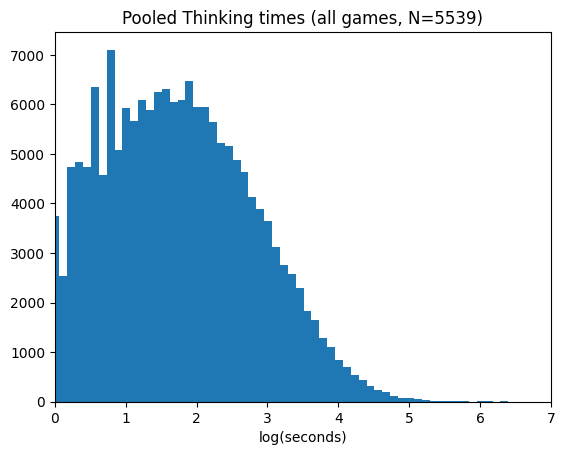

In [105]:
plt.hist(all_move_times, bins=100)
plt.xlim(0,7)
plt.title(f"Pooled Thinking times (all games, N={len(rapid_games)})")
plt.xlabel("log(seconds)")

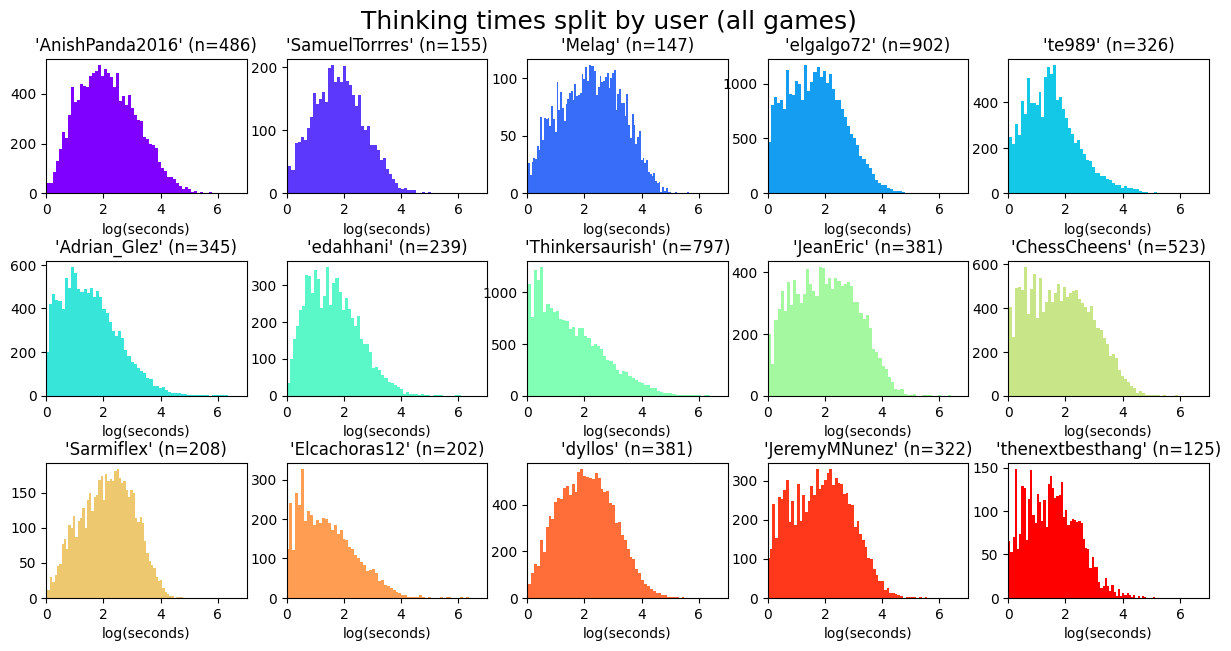

In [109]:
# Create a 5x3 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Thinking times split by user (all games)", fontsize=18, y=0.95)

# Create a color iterator
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(rapid_games.username.unique()))))

# Iterate over unique usernames and corresponding subplots
for user, ax in zip(rapid_games.username.unique(), axs.ravel()):
    by_user = rapid_games[rapid_games["username"]==user]
    think_times = list(chain.from_iterable(by_user["moveTimes"].to_list()))
    think_times = np.log([x for x in think_times if x > 0])
    
    # Plot the histogram on the specified subplot
    ax.hist(think_times, bins=100, color=next(color))
    ax.set_xlim(0, 7)
    ax.set_title(f"'{user}' (n={len(rapid_games[rapid_games["username"]==user])})")
    ax.set_xlabel("log(seconds)")

# Show the plots
plt.show()


#### Filtered for Games **with** Increment

In [118]:
rapid_games.timeFormat.value_counts()

timeFormat
{'initial': 600, 'increment': 0, 'totalTime': 600}      3618
{'initial': 600, 'increment': 5, 'totalTime': 800}       790
{'initial': 900, 'increment': 10, 'totalTime': 1300}     328
{'initial': 420, 'increment': 3, 'totalTime': 540}       111
{'initial': 900, 'increment': 5, 'totalTime': 1100}       75
                                                        ... 
{'initial': 420, 'increment': 11, 'totalTime': 860}        1
{'initial': 960, 'increment': 3, 'totalTime': 1080}        1
{'initial': 60, 'increment': 15, 'totalTime': 660}         1
{'initial': 780, 'increment': 6, 'totalTime': 1020}        1
{'initial': 720, 'increment': 7, 'totalTime': 1000}        1
Name: count, Length: 81, dtype: int64

In [123]:
with_increment = rapid_games[rapid_games["increment"] != 0]

In [124]:
move_times_increment = list(chain.from_iterable(with_increment["moveTimes"].to_list()))
move_times_increment = np.log([x for x in all_move_times if x > 0])

Text(0.5, 0, 'log(seconds)')

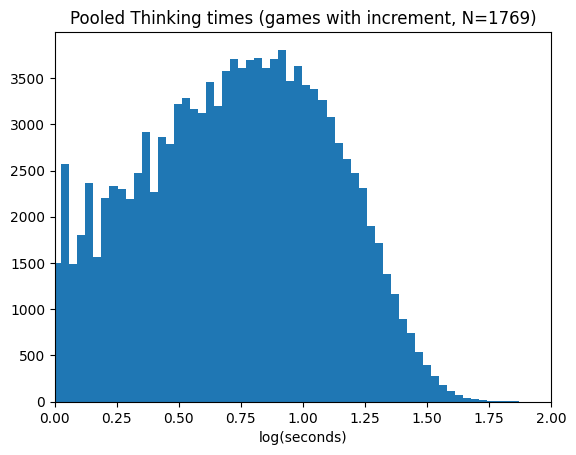

In [125]:
plt.hist(move_times_increment, bins=200)
plt.xlim(0,2)
plt.title(f"Pooled Thinking times (games with increment, N={len(with_increment)})")
plt.xlabel("log(seconds)")

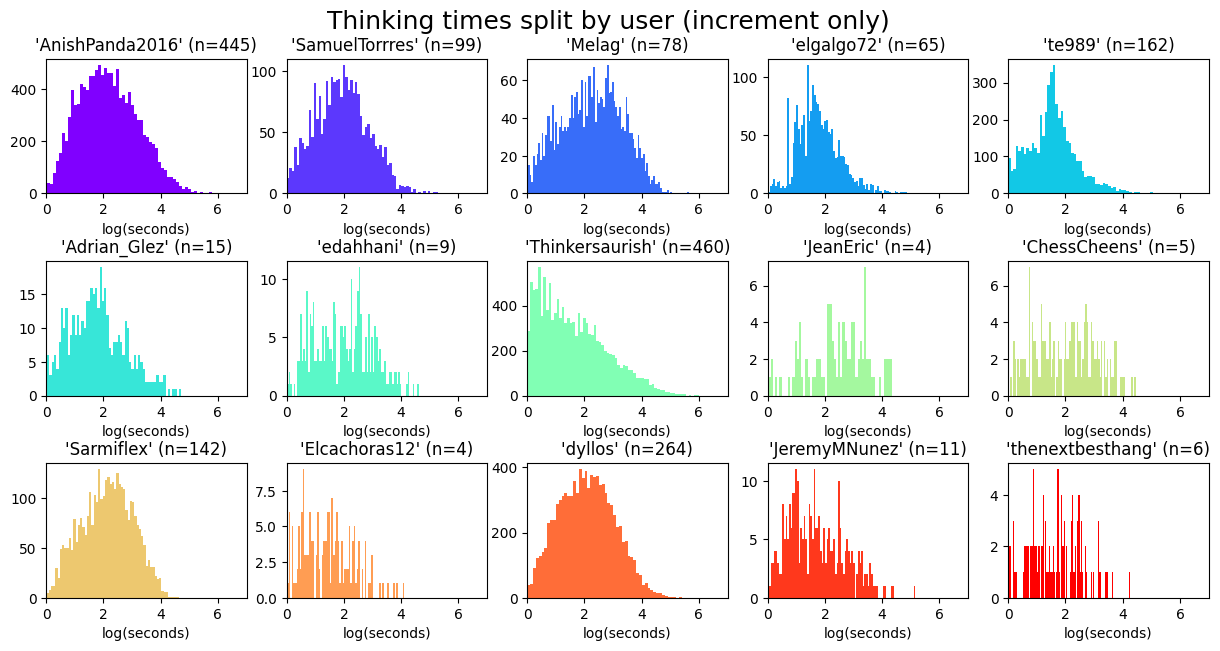

In [126]:
# Create a 5x3 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Thinking times split by user (increment only)", fontsize=18, y=0.95)

# Create a color iterator
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(with_increment.username.unique()))))

# Iterate over unique usernames and corresponding subplots
for user, ax in zip(with_increment.username.unique(), axs.ravel()):
    by_user = with_increment[with_increment["username"]==user]
    think_times = list(chain.from_iterable(by_user["moveTimes"].to_list()))
    think_times = np.log([x for x in think_times if x > 0])
    
    # Plot the histogram on the specified subplot
    ax.hist(think_times, bins=100, color=next(color))
    ax.set_xlim(0, 7)
    ax.set_title(f"'{user}' (n={len(with_increment[with_increment["username"]==user])})")
    ax.set_xlabel("log(seconds)")

# Show the plots
plt.show()

## Correlations

In [29]:
ratings = pd.read_csv("../data/rapid_ratings.csv")
ratings["date"] = pd.to_datetime(ratings["date"])
ratings["date"] = ratings["date"].apply(lambda x: x.to_pydatetime().date())

In [30]:
rapid_games["dateCreated"] = rapid_games["createdAt"].apply(lambda x: x.to_pydatetime().date())

In [31]:
for i in range(len(ratings)):
    for j in range(len(rapid_games)):
        if ratings.loc[i,"username"] == rapid_games.loc[j,"username"] and ratings.loc[i,"date"] == rapid_games.loc[j,"dateCreated"]:
            rapid_games.loc[j,"ratingOnDay"] = ratings.loc[i,"rating"]

In [48]:
cor_columns = set(rapid_games.columns)
cor_columns.remove("rated")
cor_columns.remove("increment")

cor_matrix = round(rapid_games[list(cor_columns)].corr(numeric_only=True), 2)
cor_matrix

,averaged_cp_loss,ratingOnDay,blunders
averaged_cp_loss,1.00,-0.35,0.48
ratingOnDay,-0.35,1.00,-0.35
blunders,0.48,-0.35,1.00


### Correlations per user across games

In [338]:
averages = ratings.groupby("username").mean("rating")
averages["games_played"] = rapid_games.groupby("username").count()["id"]
averages["averaged_cp_loss"] = rapid_games.groupby("username")["averaged_cp_loss"].mean()
averages["blunders"] = rapid_games.groupby("username")["blunders"].mean()
averages.corr()

C:\Users\phili\AppData\Local\Temp\ipykernel_29516\1540217686.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  averages["games_played"] = rapid_games.groupby("username").count()["id"]
C:\Users\phili\AppData\Local\Temp\ipykernel_29516\1540217686.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  averages["averaged_cp_loss"] = rapid_games.groupby("username")["averaged_cp_loss"].mean()
C:\Users\phili\AppData\Local\Temp\ipykernel_29516\1540217686.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beha

,rating,games_played,averaged_cp_loss,blunders
rating,1.000000,0.418666,-0.931887,-0.864237
games_played,0.418666,1.000000,-0.420249,-0.341715
averaged_cp_loss,-0.931887,-0.420249,1.000000,0.957064
blunders,-0.864237,-0.341715,0.957064,1.000000


### Linear Regressions & Plots

In [350]:
import pingouin as pg

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2670.753909,122.159311,21.862876,1.231271e-11,0.868414,0.858292,2406.844761,2934.663056
1,averaged_cp_loss,-16.627935,1.795184,-9.262525,4.343485e-07,0.868414,0.858292,-20.506193,-12.749676


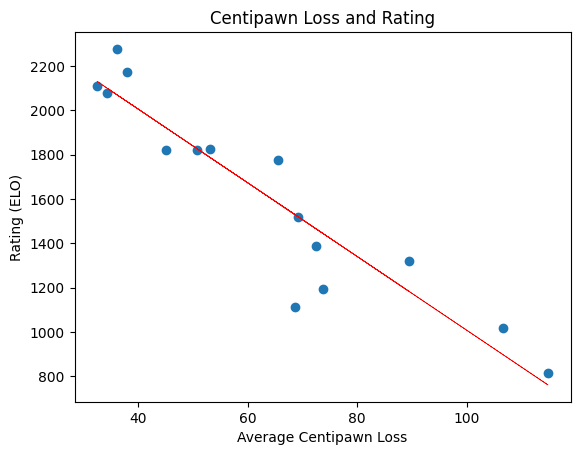

In [382]:
plt.scatter(averages["averaged_cp_loss"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["averaged_cp_loss"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]

plt.plot(averages["averaged_cp_loss"], a*averages["averaged_cp_loss"]+b, color="red", linewidth=0.5)

plt.title("Centipawn Loss and Rating")
plt.xlabel("Average Centipawn Loss")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2605.243532,171.069737,15.229132,1.144873e-09,0.746906,0.727438,2235.669835,2974.817229
1,blunders,-353.946594,57.144384,-6.193900,3.250481e-05,0.746906,0.727438,-477.399531,-230.493657


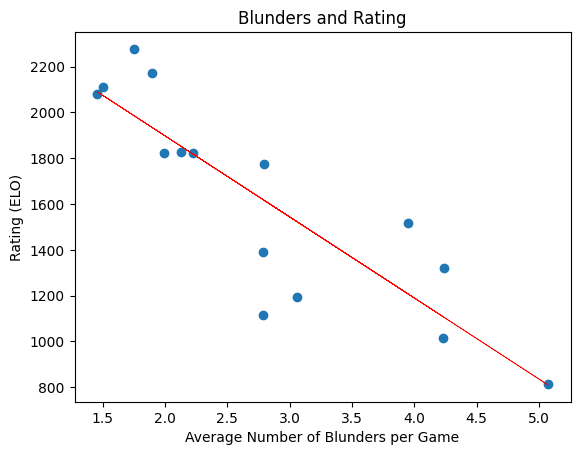

In [383]:
plt.scatter(averages["blunders"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["blunders"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["blunders"], a*averages["blunders"]+b, color="red", linewidth=0.5)

plt.title("Blunders and Rating")
plt.xlabel("Average Number of Blunders per Game")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1307.909410,216.917997,6.029511,0.000042,0.175281,0.111841,839.286569,1776.532251
1,games_played,0.837495,0.503844,1.662211,0.120380,0.175281,0.111841,-0.250994,1.925983


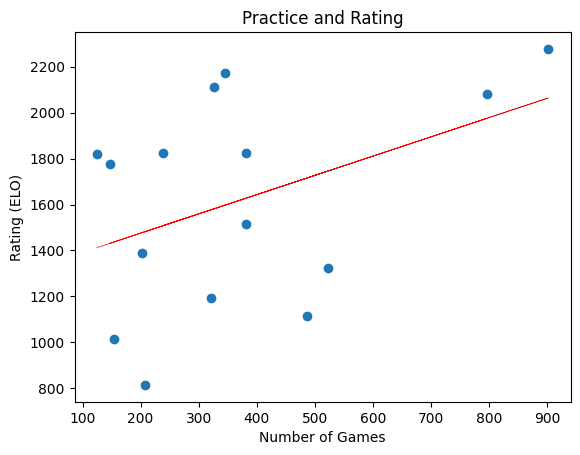

In [380]:
plt.scatter(averages["games_played"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["games_played"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["games_played"], a*averages["games_played"]+b, color="red", linewidth=0.5)

plt.title("Practice and Rating")
plt.xlabel("Number of Games")
plt.ylabel("Rating (ELO)")

fit

In [384]:
# Multiple linear regression
X = averages[['averaged_cp_loss', "blunders", 'games_played']].to_numpy()
fit = pg.linear_regression(X, averages["rating"], remove_na=True)
fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2639.893612,190.875653,13.830437,2.670127e-08,0.87757,0.84418,2219.779132,3060.008092
1,x1,-22.063584,6.911043,-3.192512,8.568135e-03,0.87757,0.84418,-37.274687,-6.852482
2,x2,132.006347,153.157814,0.861898,4.071409e-01,0.87757,0.84418,-205.091727,469.104422
3,x3,0.018328,0.238978,0.076693,9.402453e-01,0.87757,0.84418,-0.507660,0.544315


### Plotting activity per user

In [ ]:
# Define the mapping
outcome_mapping = {"win": 1, "draw": 0.5, "loss": 0}

# Apply the mapping to create a new numeric column
rapid_games["outcome_numeric"] = rapid_games["outcome"].map(outcome_mapping).astype("float")

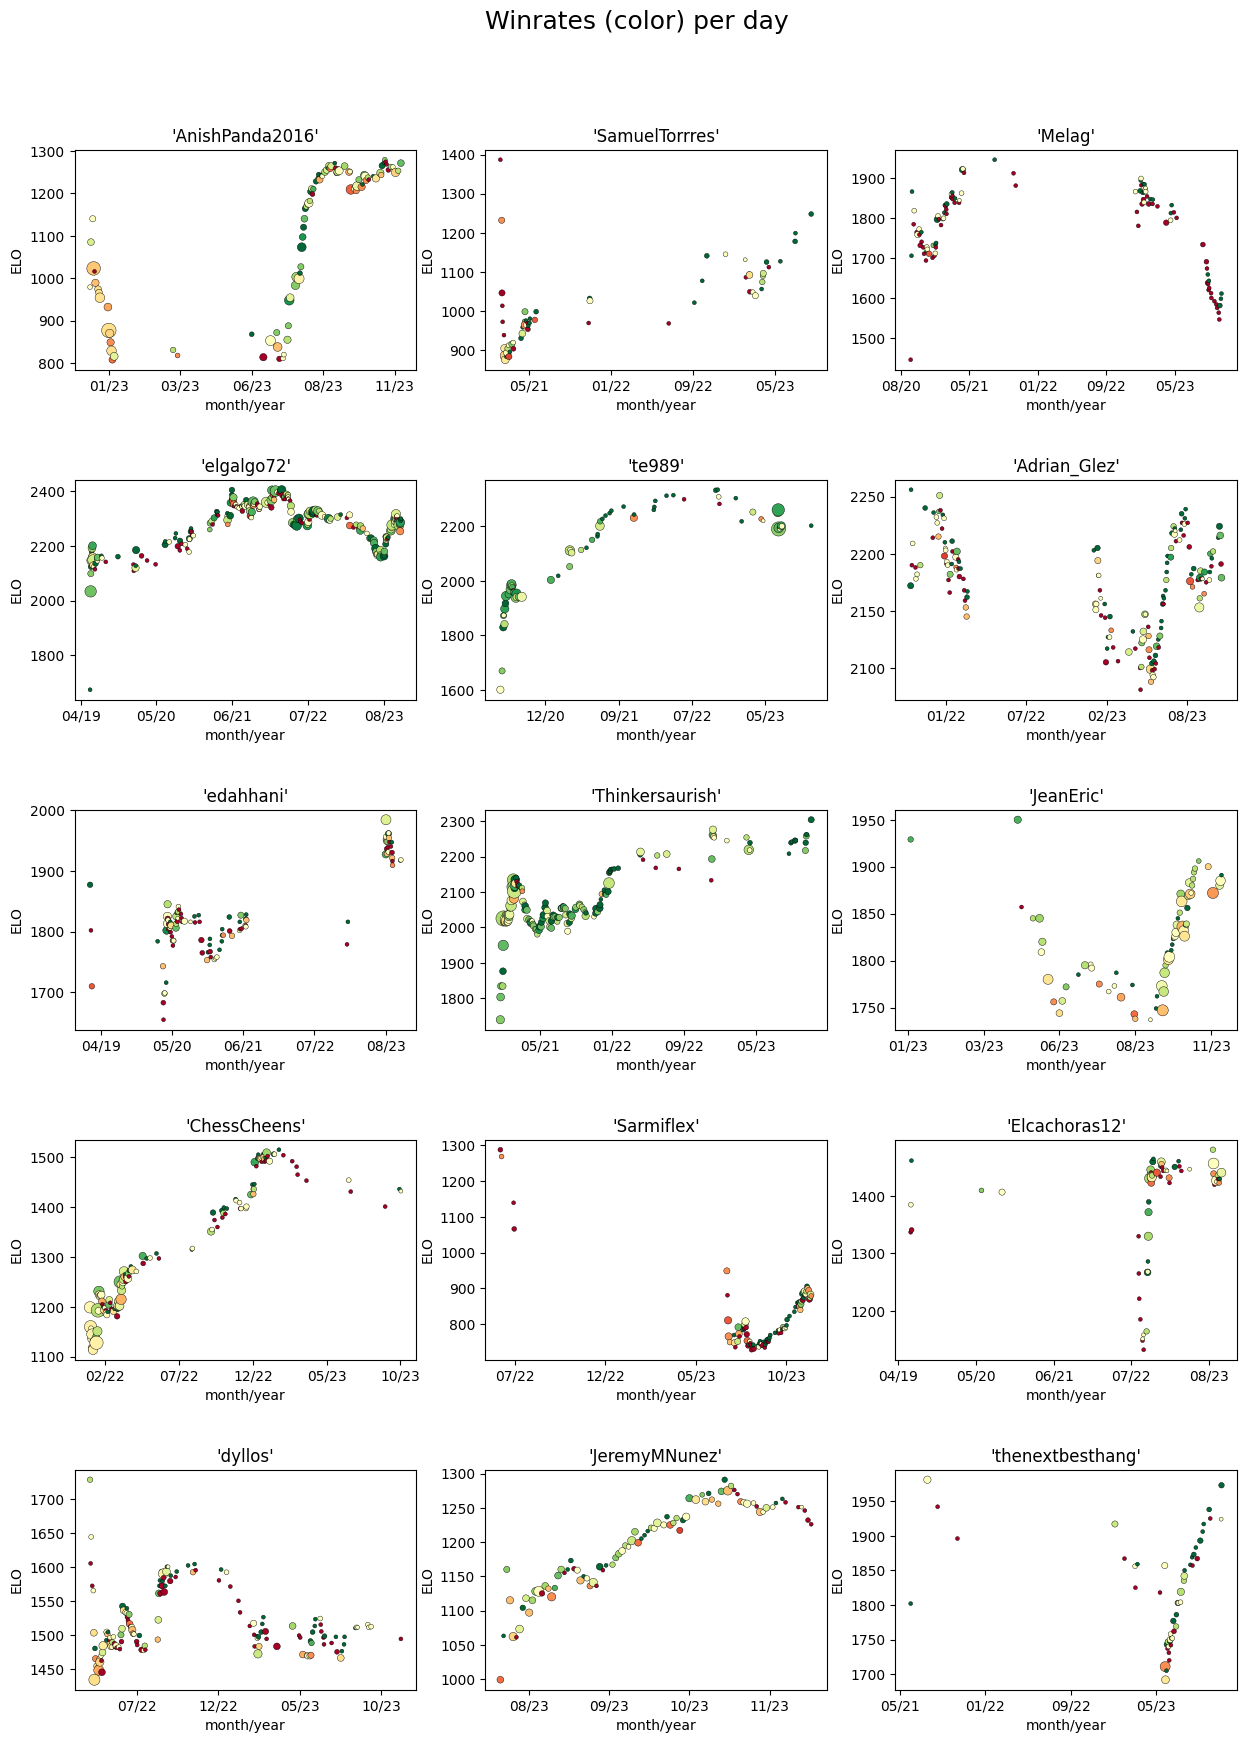

In [ ]:
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(5, 3, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Winrates (color) per day", fontsize=18, y=0.95)
plt.title("size indicates number of games played, color indicates win percentage.", fontsize=10, y=1)
for user, ax in zip(rapid_games.username.unique(), axs.ravel()):
    games_by_user = rapid_games[rapid_games["username"]==user].groupby("dateCreated")
    percentage_won = games_by_user["outcome_numeric"].mean()
    ax.scatter(
        games_by_user["ratingOnDay"].count().index, 
        games_by_user["ratingOnDay"].mean(), 
        edgecolor='black', 
        linewidth=0.3,
        s=4 + games_by_user["ratingOnDay"].count()*4, 
        c=percentage_won,  # Use percentage of games won for color
        cmap='RdYlGn',   # Choose a colormap
        alpha=1,
    ) 
    ax.set_title(f"'{user}'")
    ax.set_xlabel("month/year")
    ax.set_ylabel("ELO")
    desired_number_of_ticks=5
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=desired_number_of_ticks))
    myFmt = DateFormatter("%m/%y")
    ax.xaxis.set_major_formatter(myFmt)
    #ax.title(f"Games over time for '{user}'")

# Show the plots

plt.show()


In [2]:
import pandas as pd
rapid_ratings = pd.read_csv("../data/rapid_ratings.csv")
rapid_ratings

,username,rating,date
0,AnishPanda2016,979,2022-12-13
1,AnishPanda2016,1085,2022-12-14
2,AnishPanda2016,1140,2022-12-16
3,AnishPanda2016,1023,2022-12-17
4,AnishPanda2016,1016,2022-12-18
...,...,...,...
3034,thenextbesthang,1917,2023-10-09
3035,thenextbesthang,1938,2023-10-25
3036,thenextbesthang,1925,2023-10-28
3037,thenextbesthang,1924,2023-11-29


In [3]:
puzzle_ratings = pd.read_csv("../data/puzzle_ratings.csv")
puzzle_ratings

,Unnamed: 0,username,rating,date
0,0,AnishPanda2016,1518,2022-11-17
1,1,AnishPanda2016,1402,2022-11-21
2,2,AnishPanda2016,1482,2022-11-22
3,3,AnishPanda2016,1518,2022-11-23
4,4,AnishPanda2016,1377,2022-11-27
...,...,...,...,...
1211,68,thenextbesthang,1757,2023-11-27
1212,69,thenextbesthang,1853,2023-11-28
1213,70,thenextbesthang,1866,2023-11-29
1214,71,thenextbesthang,1828,2023-11-30
